In [1]:
!pip freeze | grep -E "qiskit|scikit-learn"

qiskit==0.44.0
qiskit-aer==0.12.0
qiskit-algorithms==0.3.1
qiskit-ibmq-provider==0.20.2
qiskit-ignis==0.7.1
qiskit-machine-learning==0.7.2
qiskit-nature==0.6.2
qiskit-terra==0.25.0
scikit-learn==1.6.1


In [2]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from sklearn.metrics import normalized_mutual_info_score
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from sklearn.cluster import SpectralClustering
from qiskit.primitives import Sampler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np

sampler = Sampler()

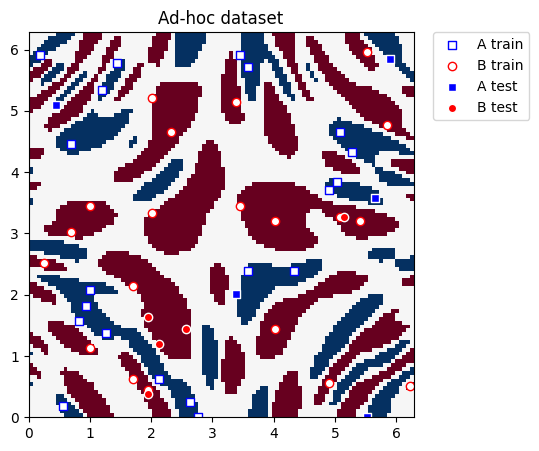

In [3]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)

plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],
    test_features[np.where(test_labels[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)

plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],
    test_features[np.where(test_labels[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad-hoc dataset")
plt.show()

In [4]:
adhoc_feature_map = ZZFeatureMap(
    feature_dimension=adhoc_dimension, reps=2, entanglement="linear"
)
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [5]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_features, train_labels)
adhoc_score = adhoc_svc.score(test_features, test_labels)
print(f"Callable kernel classification test score: {adhoc_score}")

Callable kernel classification test score: 1.0


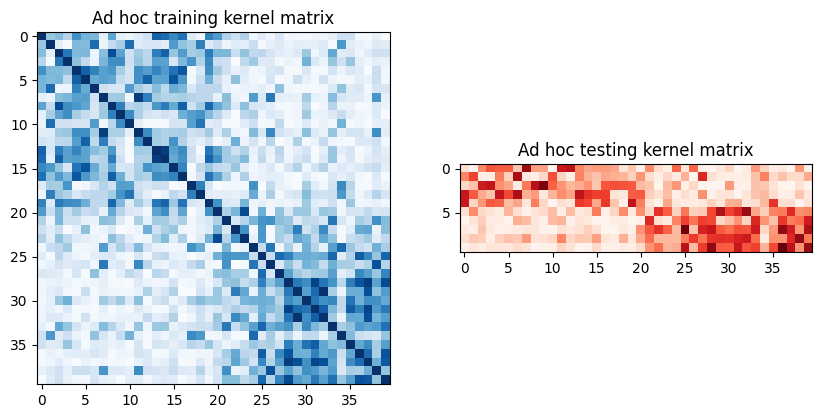

Precomputed kernel classification test score: 1.0


In [6]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train),
    interpolation="nearest",
    origin="upper",
    cmap="Blues",
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(
    np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds"
)
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

adhoc_svc = SVC(kernel="precomputed")
adhoc_svc.fit(adhoc_matrix_train, train_labels)
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)
print(f"Precomputed kernel classification test score: {adhoc_score}")

### QSVC

In [7]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


### Clustering

In [8]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

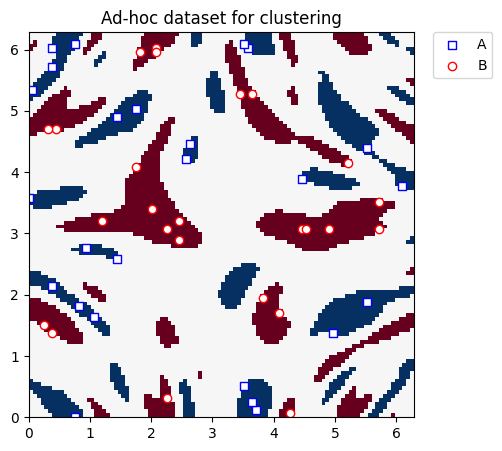

In [9]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A",
)

plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad-hoc dataset for clustering")

plt.show()

In [10]:
adhoc_feature_map = ZZFeatureMap(
    feature_dimension=adhoc_dimension, reps=2, entanglement="linear"
)
adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

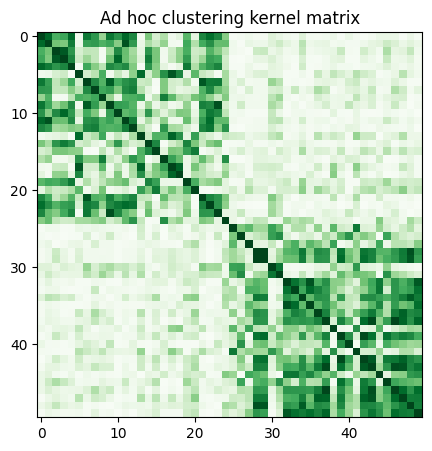

Clustering score: 0.7577078109175855


In [11]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5, 5))
plt.imshow(
    np.asmatrix(adhoc_matrix), interpolation="nearest", origin="upper", cmap="Greens"
)
plt.title("Ad hoc clustering kernel matrix")
plt.show()

adhoc_spectral = SpectralClustering(2, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)
cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

print(f"Clustering score: {cluster_score}")